# TEM Image Processing Pipeline

In this notebook we implement an image processing pipeline to extract information from transmission electron microscopy images of barium titanate nanoparticles in a low density polyethylene _matrix_. Information gained from this process includes the:
- number of particles, $N_p$
- number of agglomerates, $N_a$
- size of particles (longest and shortest chord lengths)
- locations of particles (x,y)
- number of particles per agglomerate, $n$
- factor of agglomeration

where factor of agglomeration is given by:
$$F_a = \frac{N_a \cdot n}{N_p}$$

#### Steps:

Load Input: We don't need to process input image with 3 color channels as TEM images tend to be grayscale. Each pixel is 8 bits ranging from 0 (light) to 255 (dark).

Gaussian Blur: TEM images have noise (looks like a fine grain filter accross image). To smooth out these grains we apply a gaussian blur.
TODO: explain kernel matrix

Binary Threshold: Convert grayscale pixels to only take on values of 0 (light) or 1 (dark). This helps us reduce image size for faster processing but also results in a significant loss of information from the original image.
TODO: explain OTSU's method

## 1. Import necessary libraries and define constants

Import libraries

In [1]:
import cv2 as cv                   # OpenCV for image processing
import matplotlib.pyplot as plt    # Matplotlib for visualizing
from mpl_toolkits.mplot3d import Axes3D # Axes3D for 3D visualization
import numpy as np                 # NumPy for quick maths
from collections import Counter    # dictionary quick maths
from tem_functions import *        # import necessary functions from separate python file
import timeit                      # timing how long it takes to import libraries
from scipy.optimize import fsolve  # used for solving system of nonlin eqs. (particle intersections)
import warnings                    # used for particle intersections
warnings.filterwarnings("ignore", category=RuntimeWarning) # used for particle intersections
import time                        # timing how long it takes to import libraries
from numba import jit, njit, types, typeof  # optimization library
from numba.typed import Dict, List          # optimized data structures


t_pipe_init = time.perf_counter()  # begin timing pipeline

Define constants

In [2]:
# threshold_1 = 55 # for 36a
# threshold_1 = 99 # for 500nm_epoxy_2
# threshold_1 = 70 # for 500nm_epoxy_15
# threshold_1 = 55 # for 36a
threshold_1 = 35 # for 36b
# threshold_1 = 45 # for 36e
# threshold_1 = 55 # for 36h

print(str(nm_per_pixel), "nm per pixel")
print(str(expected_radius), "nm is expected particle radius")

0.8849557522123894 nm per pixel
100 nm is expected particle radius


## 2. Setup

grayscale, gaussian blur, binary threshold, noise removel, dilation, distance transform

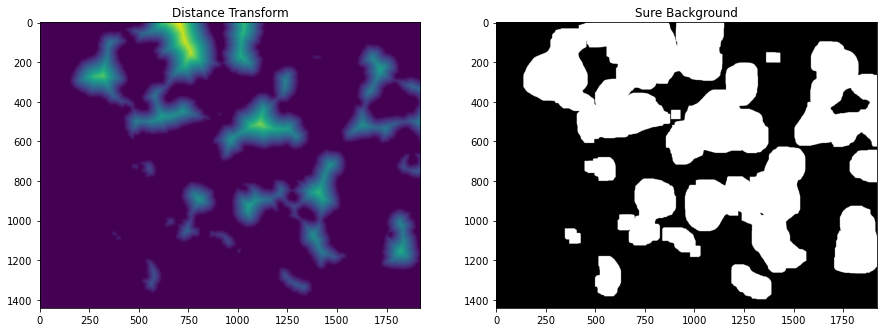

In [3]:
# display images inline in notebook, comment can't be on same line (glitch)
%matplotlib inline 

# IMAGE_NAME_1 = "./inputs/TES-36a-cropped.tif"
IMAGE_NAME_1 = "./inputs/TES-36b-cropped.tif"
# IMAGE_NAME_1 = "./inputs/TES-36e-cropped.tif"
# IMAGE_NAME_1 = "./inputs/TES-36h-cropped.tif"
# IMAGE_NAME_1 = "./inputs/500nm_epoxy/500nm_epoxy_2.jpg"
# IMAGE_NAME_1 = "./inputs/500nm_epoxy/500nm_epoxy_15.jpg"
# IMAGE_NAME_1 = "./inputs/500nm_epoxy/500nm_epoxy_22.jpg"

color_image_1, dist_transform_1, sure_bg_1 = setup(IMAGE_NAME_1, threshold_1, False)
# color_image_2, dist_transform_2, sure_bg_2 = setup(IMAGE_NAME_2, threshold_2, False)
# color_image_3, dist_transform_3, sure_bg_3 = setup(IMAGE_NAME_3, threshold_3, False)

## 3. Perform watershed and find contours

Find the threshold value that will break up agglomerates into individual particles

In [4]:
dist_transform_thresh_1 = get_watershed_threshold(dist_transform_1, sure_bg_1, color_image_1, expected_radius)
# dist_transform_thresh_2 = get_watershed_threshold(dist_transform_2, sure_bg_2, color_image_2, expected_radius)
# dist_transform_thresh_3 = get_watershed_threshold(dist_transform_3, sure_bg_3, color_image_3, expected_radius)

Get watershed markers

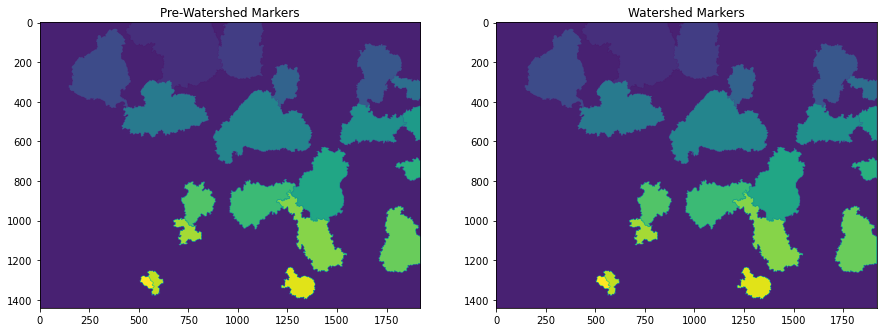

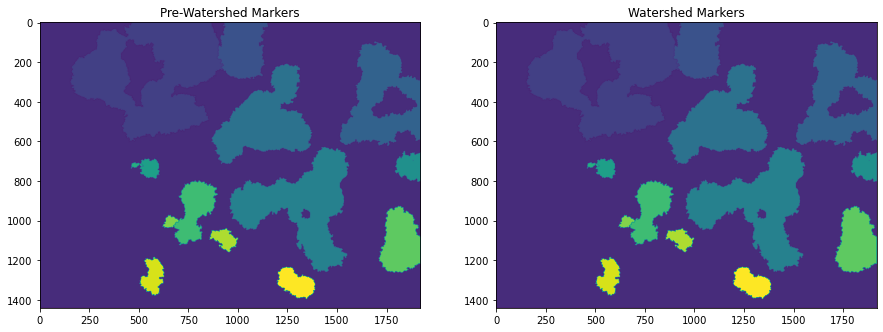

In [5]:
# watershed markers for finding particles (no agglomerates)
watershed_markers_1 = get_watershed_markers(dist_transform_1, dist_transform_thresh_1, sure_bg_1, color_image_1, True)
# watershed_markers_2 = get_watershed_markers(dist_transform_2, dist_transform_thresh_2, sure_bg_2, color_image_2, False)
# watershed_markers_3 = get_watershed_markers(dist_transform_3, dist_transform_thresh_3, sure_bg_3, color_image_3, False)

# watershed markers for finding agglomerates
agg_watershed_markers_1 = get_watershed_markers(dist_transform_1, 0.1, sure_bg_1, color_image_1, True)
# agg_watershed_markers_2 = get_watershed_markers(dist_transform_2, 0.1, sure_bg_2, color_image_2, False)
# agg_watershed_markers_3 = get_watershed_markers(dist_transform_3, 0.1, sure_bg_3, color_image_3, False)

Get contours

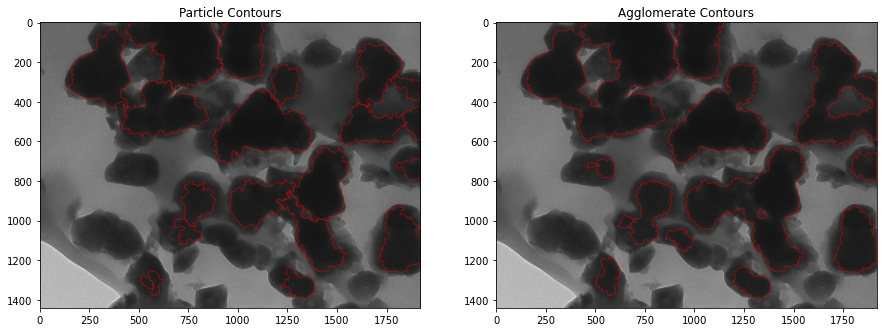

In [6]:
contour_colors_1, chords_color_copy_1 = get_contour_colors(watershed_markers_1, color_image_1)
# contour_colors_2, chords_color_copy_2 = get_contour_colors(watershed_markers_2, color_image_2)
# contour_colors_3, chords_color_copy_3 = get_contour_colors(watershed_markers_3, color_image_3)

agg_contour_colors_1, agg_chords_color_copy_1 = get_contour_colors(agg_watershed_markers_1, color_image_1)
# agg_contour_colors_2, agg_chords_color_copy_2 = get_contour_colors(agg_watershed_markers_2, color_image_2)
# agg_contour_colors_3, agg_chords_color_copy_3 = get_contour_colors(agg_watershed_markers_3, color_image_3)

display_images([chords_color_copy_1, agg_chords_color_copy_1], ["Particle Contours", "Agglomerate Contours"], [1, 1])
# display_images([chords_color_copy_2, agg_chords_color_copy_2], ["Particle Contours", "Agglomerate Contours"], [1, 1])
# display_images([chords_color_copy_3, agg_chords_color_copy_3], ["Particle Contours", "Agglomerate Contours"], [1, 1])

## 4. Finding centerpoints, getting areas, and replacing agglomerates with particles

Finding centerpoints

In [7]:
particles_1 = find_centerpoints(contour_colors_1)
# particles_2 = find_centerpoints(contour_colors_2)
# particles_3 = find_centerpoints(contour_colors_3)

agg_particles_1 = find_centerpoints(agg_contour_colors_1)
# agg_particles_2 = find_centerpoints(agg_contour_colors_2)
# agg_particles_3 = find_centerpoints(agg_contour_colors_3)

Getting areas

In [8]:
particle_areas_1 = get_areas(watershed_markers_1)
# particle_areas_2 = get_areas(watershed_markers_2)
# particle_areas_3 = get_areas(watershed_markers_3)

agg_areas_1 = get_areas(agg_watershed_markers_1)
# agg_areas_2 = get_areas(agg_watershed_markers_2)
# agg_areas_3 = get_areas(agg_watershed_markers_3)

Replacing agglomerates with particles

In [9]:
# TODO: standardize way of referring to unique particle ID, here particle == color
# TODO: make v2 of function that defines agglomerate area by contour not min/max rectangle

merge_particles_1, merge_contour_colors_1 = match_images(particles_1, contour_colors_1, agg_particles_1, agg_contour_colors_1, agg_areas_1)
# merge_particles_2, merge_contour_colors_2 = match_images(particles_2, contour_colors_2, agg_particles_2, agg_contour_colors_2, agg_areas_2)
# merge_particles_3, merge_contour_colors_3 = match_images(particles_3, contour_colors_3, agg_particles_3, agg_contour_colors_3, agg_areas_3)
# [print(x, merge_particles[x]) for x in merge_particles.keys()]

## 5. Get long and short chord lengths

Get long chord lengths

In [10]:
long_pairs_1, merge_particles_1, merge_contour_colors_1 = get_long_chord_lengths(merge_particles_1, particles_1, contour_colors_1, merge_contour_colors_1)
# long_pairs_2, merge_particles_2 = get_long_chord_lengths(merge_particles_2, merge_contour_colors_2)
# long_pairs_3, merge_particles_3 = get_long_chord_lengths(merge_particles_3, merge_contour_colors_3)


In [11]:
print(long_pairs_1)

[[17, (349, 37), (439, 430)], [18, (422, 432), (842, 458)], [3, (926, 3), (1118, 273)], [19, (1502, 634), (1367, 997)], [20, (1286, 817), (956, 959)], [7, (1837, 649), (1917, 801)], [8, (510, 696), (601, 768)], [9, (461, 712), (521, 724)], [10, (802, 798), (701, 1121)], [11, (1806, 926), (1819, 1263)], [12, (693, 989), (620, 1020)], [13, (865, 1048), (987, 1133)], [14, (575, 1183), (578, 1377)], [15, (1199, 1258), (1380, 1363)], [22, (430, 42), (920, 239)], [23, (1660, 107), (1648, 430)], [24, (1783, 271), (1909, 393)], [25, (1826, 470), (1512, 594)], [26, (1914, 421), (1893, 599)], [27, (1236, 211), (1213, 431)], [28, (1369, 547), (871, 578)], [29, (1257, 846), (1523, 1229)]]


Get short chord lengths

In [12]:
short_pairs_1, merge_particles_1 = get_short_chord_lengths(merge_particles_1, merge_contour_colors_1, long_pairs_1)
# short_pairs_2, merge_particles_2 = get_short_chord_lengths(merge_particles_2, merge_contour_colors_2, long_pairs_2)
# short_pairs_3, merge_particles_3 = get_short_chord_lengths(merge_particles_3, merge_contour_colors_3, long_pairs_3)

print(merge_particles_1)

{16: [('x', 590.8097600900303), ('y', 143.6509966409194), ('a', 233.68068935681336), ('theta', -158.0978596407897), ('b', 101.92850282579266)], 17: [('x', 274.6185102278307), ('y', 225.19127647811584), ('a', 178.3954247141215), ('theta', -102.89875110416445), ('b', 123.84638789191955)], 18: [('x', 531.7295469346958), ('y', 395.76119777246083), ('a', 186.1964568037603), ('theta', -176.4576388078063), ('b', 117.18314611302677)], 3: [('x', 895.5926809071046), ('y', 125.20427811754845), ('a', 146.59579850207282), ('theta', -125.41705527646744), ('b', 134.08904925547537)], 4: [('x', 1526.474010346592), ('y', 353.5337590722177)], 5: [('x', 999.5743281868345), ('y', 424.4919539440272)], 19: [('x', 1249.0590940578031), ('y', 718.6922821529141), ('a', 171.36751706928675), ('theta', -69.59979060515747), ('b', 94.22701171150217)], 20: [('x', 981.0207920417104), ('y', 790.0963225733151), ('a', 158.96229391191767), ('theta', -23.28235621348973), ('b', 88.63926387864245)], 21: [('x', 1196.8341703661

Display chord lengths

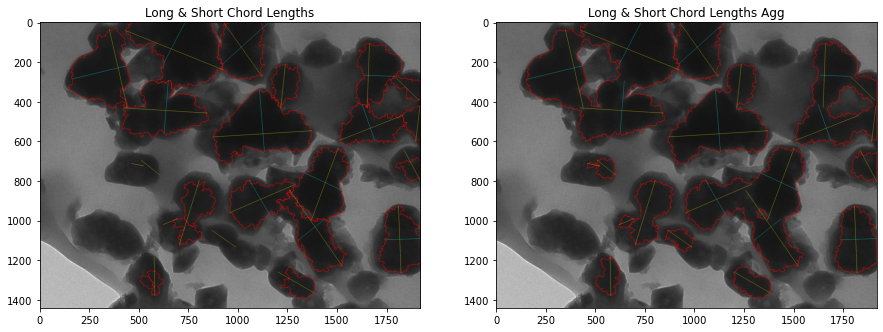

In [13]:
# draw_long_lengths(chords_color_copy, long_pairs)
# draw_short_lengths(chords_color_copy, short_pairs)
# display_images([chords_color_copy], ["Long & Short Chord Lengths"], [0])
# plt.savefig("chords_color_copy_long_short_chord_lengths.png", dpi=500)

draw_long_lengths(chords_color_copy_1, long_pairs_1)
# draw_long_lengths(chords_color_copy_2, long_pairs_2)
# draw_long_lengths(chords_color_copy_3, long_pairs_3)

draw_long_lengths(agg_chords_color_copy_1, long_pairs_1)
# draw_long_lengths(agg_chords_color_copy_2, long_pairs_2)
# draw_long_lengths(agg_chords_color_copy_3, long_pairs_3)

draw_short_lengths(chords_color_copy_1, short_pairs_1)
# draw_short_lengths(chords_color_copy_2, short_pairs_2)
# draw_short_lengths(chords_color_copy_3, short_pairs_3)

draw_short_lengths(agg_chords_color_copy_1, short_pairs_1)
# draw_short_lengths(agg_chords_color_copy_2, short_pairs_2)
# draw_short_lengths(agg_chords_color_copy_3, short_pairs_3)

display_images([chords_color_copy_1, agg_chords_color_copy_1], ["Long & Short Chord Lengths", "Long & Short Chord Lengths Agg"], [0, 0])
# plt.savefig("500nm_epoxy_15_chord_lengths.png", dpi=500)

# draw_long_lengths(agg_chords_color_copy, long_pairs)
# draw_short_lengths(agg_chords_color_copy, short_pairs)
# display_images([agg_chords_color_copy], ["Agg Long & Short Chord Lengths"], [0])
plt.savefig("./visualizations/36b_troubleshooting.png", dpi=500)

In [14]:
# display_images([chords_color_copy_1], ["Long & Short Chord Lengths Layer a"], [0])
# display_images([chords_color_copy_2], ["Long & Short Chord Lengths Layer b"], [0])
# display_images([chords_color_copy_3], ["Long & Short Chord Lengths Layer e"], [0])

# plt.savefig("long_short_chord_lengths_a.png", dpi=500)

## 6. Get c radii and layer information

In [15]:
merge_particles_1 = get_c(merge_particles_1)
# merge_particles_2 = get_c(merge_particles_2)
# merge_particles_3 = get_c(merge_particles_3)

print(merge_particles_1)

{16: [('x', 590.8097600900303), ('y', 143.6509966409194), ('a', 233.68068935681336), ('theta', -158.0978596407897), ('b', 101.92850282579266), ('c', 167.804596091303)], 17: [('x', 274.6185102278307), ('y', 225.19127647811584), ('a', 178.3954247141215), ('theta', -102.89875110416445), ('b', 123.84638789191955), ('c', 151.12090630302052)], 18: [('x', 531.7295469346958), ('y', 395.76119777246083), ('a', 186.1964568037603), ('theta', -176.4576388078063), ('b', 117.18314611302677), ('c', 151.68980145839353)], 3: [('x', 895.5926809071046), ('y', 125.20427811754845), ('a', 146.59579850207282), ('theta', -125.41705527646744), ('b', 134.08904925547537), ('c', 140.3424238787741)], 4: [('x', 1526.474010346592), ('y', 353.5337590722177)], 5: [('x', 999.5743281868345), ('y', 424.4919539440272)], 19: [('x', 1249.0590940578031), ('y', 718.6922821529141), ('a', 171.36751706928675), ('theta', -69.59979060515747), ('b', 94.22701171150217), ('c', 132.79726439039445)], 20: [('x', 981.0207920417104), ('y',

In [16]:
intersections = layer_check_intersections(merge_particles_1)
print(intersections)

[[16, 22], [17, 18], [3, 16], [3, 22], [19, 21], [19, 29], [20, 21], [20, 29], [23, 25]]


In [17]:
# merge_particles_1 = layer_xy_rotate_particles(merge_particles_1)
# intersections = layer_check_intersections(merge_particles_1)
# print(intersections)
merge_particles_1 = layer_scale_particles(merge_particles_1)
intersections = layer_check_intersections(merge_particles_1)
print(intersections)

[]


In [18]:
info_1 = get_layer_info(merge_particles_1)
# info_2 = get_layer_info(merge_particles_2)
# info_3 = get_layer_info(merge_particles_3)

print(info_1)
# print(info_2)
# print(info_3)

[1635.8635499241318, 1189.246645503106, 106.66275911552478, -67.68563008908333, 178.29726992258804, 121640315.73156105, 0.17534114532319844]


## 7. Render layer

<IPython.core.display.Javascript object>


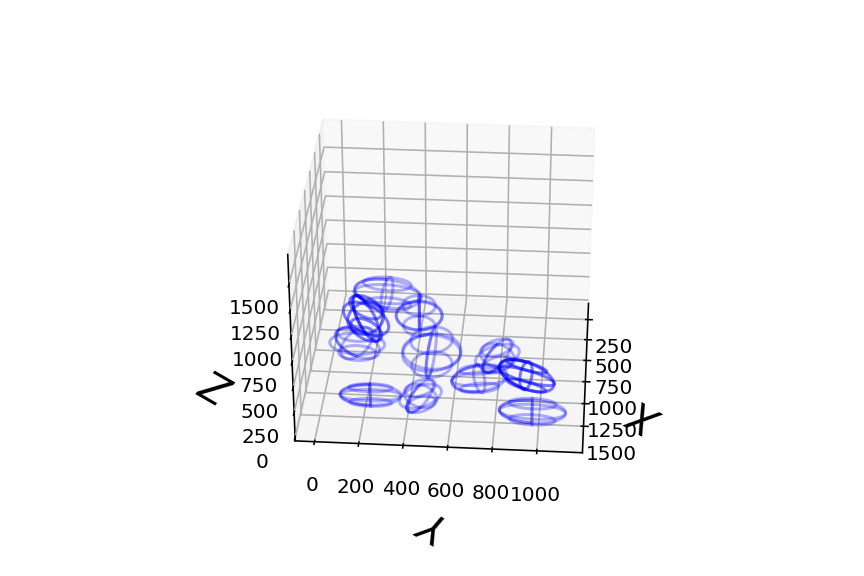

<IPython.core.display.Javascript object>


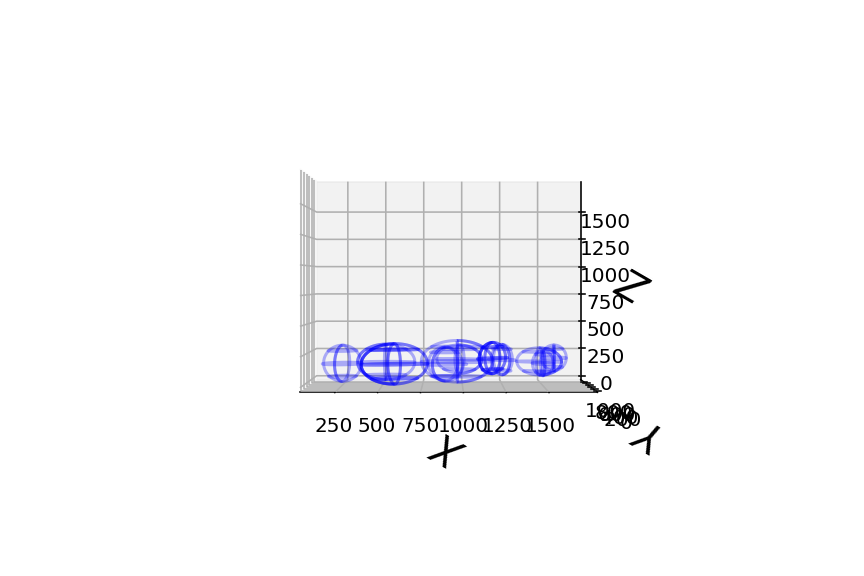

<IPython.core.display.Javascript object>


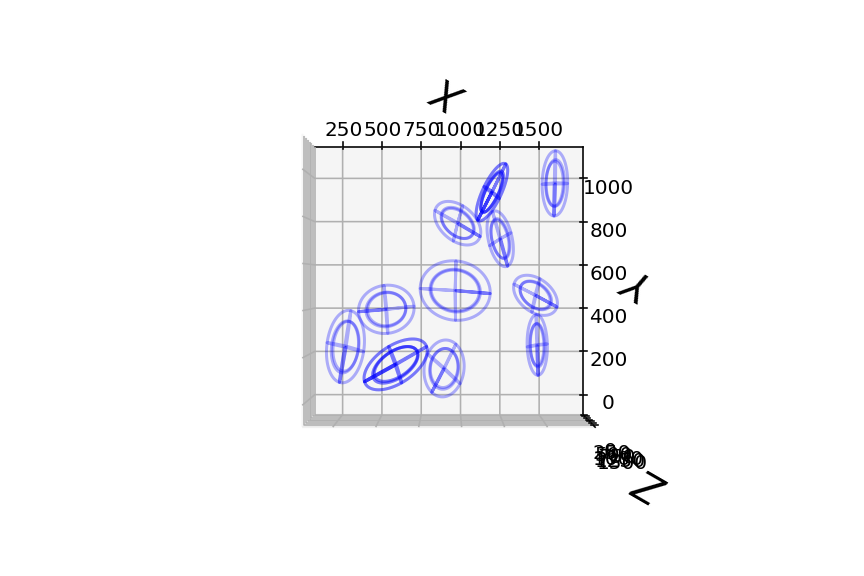

In [24]:
%matplotlib notebook

layer_render(merge_particles_1, info_1)

## 8. Combine layers and save to a text file

In [20]:
# combine_layers([merge_particles_1,merge_particles_2,merge_particles_3], [info_1, info_2, info_3], "max_c_abe.txt")
# combine_layers([merge_particles_1,merge_particles_3,merge_particles_2], [info_1, info_3, info_2], "max_c_aeb.txt")
# combine_layers([merge_particles_2,merge_particles_1,merge_particles_3], [info_2, info_1, info_3], "max_c_bae.txt")
# combine_layers([merge_particles_2,merge_particles_3,merge_particles_1], [info_2, info_3, info_1], "max_c_bea.txt")
# combine_layers([merge_particles_3,merge_particles_1,merge_particles_2], [info_3, info_1, info_2], "max_c_eab.txt")
# combine_layers([merge_particles_3,merge_particles_2,merge_particles_1], [info_3, info_2, info_1], "max_c_eba.txt")



In [21]:
# combine_layers([merge_particles_2,merge_particles_3], [info_2, info_3], "two_layer_be.txt")

In [22]:
# combine_layers([merge_particles_1], [info_1], "./500nm_epoxy/500nm_epoxy_15.txt")
# combine_layers([merge_particles_2], [info_2], "layer_b.txt")
# combine_layers([merge_particles_3], [info_3], "layer_e.txt")
# combine_layers([merge_particles_1], [info_1], "layer_h_again.txt")

In [23]:
t_pipe_final = time.perf_counter()

print("time to run pipeline:", str(t_pipe_final - t_pipe_init), "seconds")

time to run pipeline: 42.4046997220139 seconds
